In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")


    def gradient_descent(self):
            for i in range(1, self.max_iterations + 1):
                Y_predict = self.predict(self.X).flatten()

                soft_term = self.soft_threshold(self.W, self.l1_penalty)
                dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
                new_W = self.W - self.step_size * dW

                if np.mean(np.abs(new_W - self.W)) < self.tolerance:
                    break

                self.J.append((np.mean(np.abs(new_W - self.W)),))
                self.W = new_W
                self.iterations = i


    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            if r_norm < tol_prim and s_norm < tol_dual:
                break

        self.W = self.W.reshape(1, -1)


    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        print(f"Total rows used: {total_rows_used}")
        print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)  


In [5]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

In [6]:
def loss_plot(J, title):
    plt.plot(J, color='brown')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [7]:
def loss_plot_admm(J, title):
    
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    # Crea il grafico
    plt.plot(r_loss, label='primary residual', color='purple')
    plt.plot(s_loss, label='dual residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()


# Generation of synthetic data

## First simple Dataset

A dataset is generated to perform an initial training and test phase

In [8]:
n_features = 3

X_num = np.random.rand(100, n_features)
X_cat = np.random.randint(0, 2, (100, 1))
X = np.concatenate((X_num, X_cat), axis=1)

y = 2 * X[:, 0] + X[:, 1] + 0.1 * np.random.randn(100)

In [9]:
print(X.shape)

X_dataframe = pd.DataFrame(X, columns=["X1", "X2", "X3", "X4"])
print(X_dataframe.head())

(100, 4)
         X1        X2        X3   X4
0  0.447804  0.928873  0.827794  1.0
1  0.513307  0.748899  0.517076  1.0
2  0.969225  0.762449  0.003408  0.0
3  0.755490  0.167863  0.793617  1.0
4  0.123287  0.361359  0.644539  1.0


visualisation of generated data

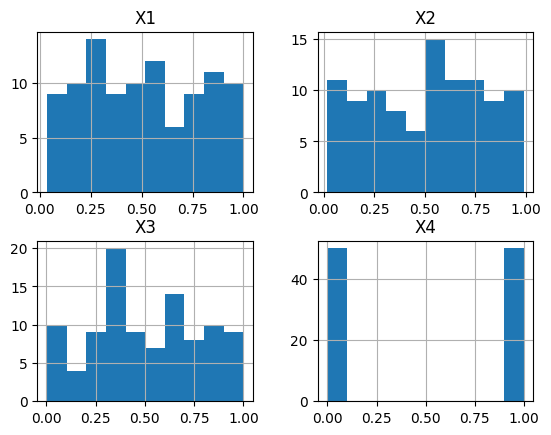

In [10]:
#histogram
X_dataframe.hist()
plt.show()


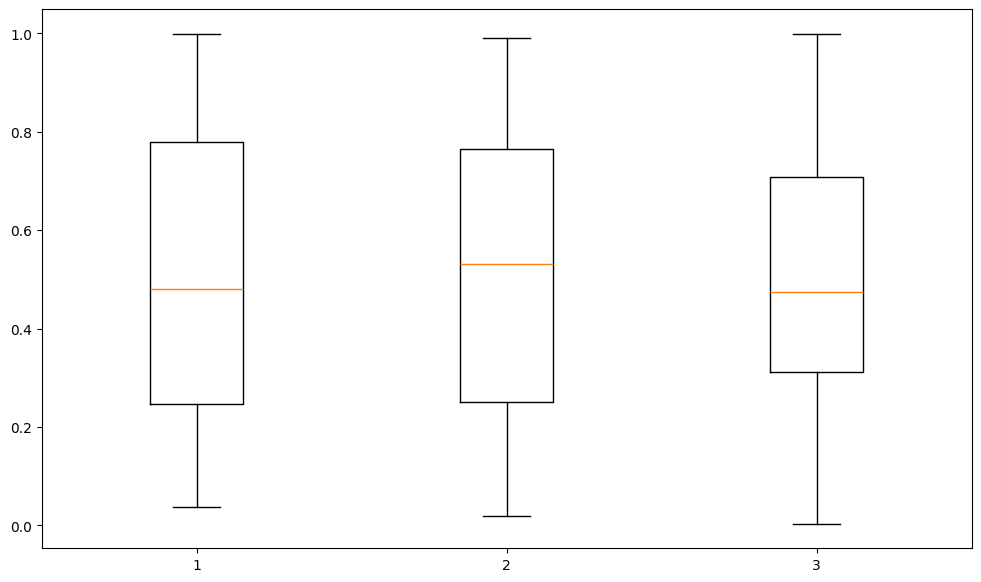

In [11]:
plt.figure(figsize=(12, 7))
plt.boxplot(X_num)
plt.show()

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#lasso parameters
step_size = 0.5
max_iterations = 10000
l1_penalty = 0.1
tolerance = 1e-2
agents = 5

Gradient Descent Lasso

In [14]:
star_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train, y_train, "gd")
iterations = lasso_gd.iterations
print("GD iterations:", iterations)
lasso_gd_predictions = lasso_gd.predict(X_test)
end_time = time.time()
print("GD time:", end_time - star_time)

GD iterations: 18
GD time: 0.0019998550415039062


In [15]:
#metrics
gd_mse = mean_squared_error(y_test, lasso_gd_predictions)
print("GD MSE:", gd_mse)

r2 = r2_score(y_test, lasso_gd_predictions)
print("GD R2:", r2)

mae = mean_absolute_error(y_test, lasso_gd_predictions)
print("GD MAE:", mae)

GD MSE: 0.02324357548324505
GD R2: 0.892558369653153
GD MAE: 0.1308184171732321


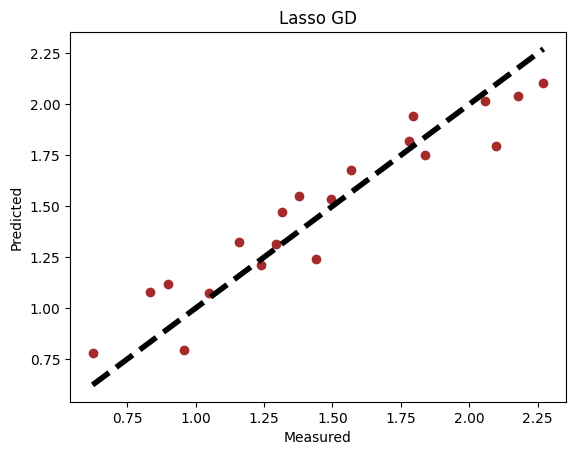

In [16]:
prediction_plot(y_test, lasso_gd_predictions, "Lasso GD")

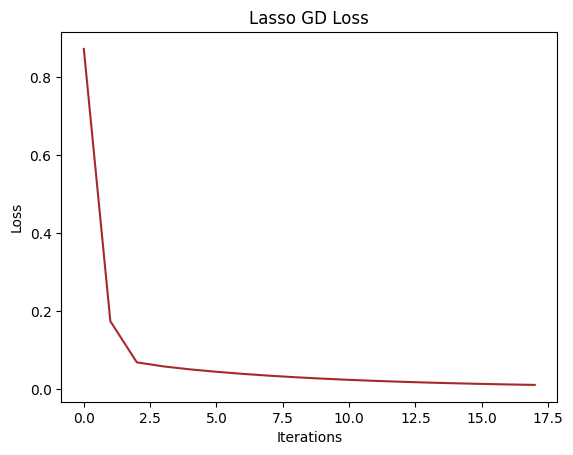

In [17]:
loss_plot(lasso_gd.J, "Lasso GD Loss")

ADMM Lasso

In [18]:
star_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, y_train, "admm")
iterations = lasso_admm.iterations
print("ADMM iterations:", iterations)
lasso_admm_predictions = lasso_admm.predict(X_test)
end_time = time.time()
print("ADMM time:", end_time - star_time)

ADMM iterations: 2
ADMM time: 0.0009961128234863281


In [19]:
#metrics
admm_mse = mean_squared_error(y_test, lasso_admm_predictions)
print("ADMM MSE:", admm_mse)

admm_r2 = r2_score(y_test, lasso_admm_predictions)
print("ADMM R2:", admm_r2)

admm_mae = mean_absolute_error(y_test, lasso_admm_predictions)
print("ADMM MAE:", admm_mae)

ADMM MSE: 0.008616452726589948
ADMM R2: 0.9601711135440978
ADMM MAE: 0.07690417919322769


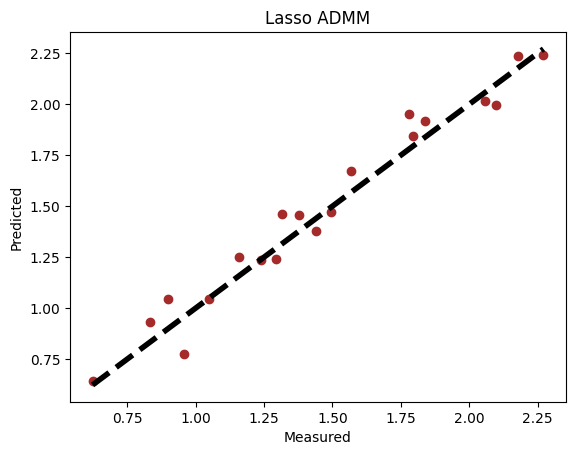

In [20]:
prediction_plot(y_test, lasso_admm_predictions, "Lasso ADMM")

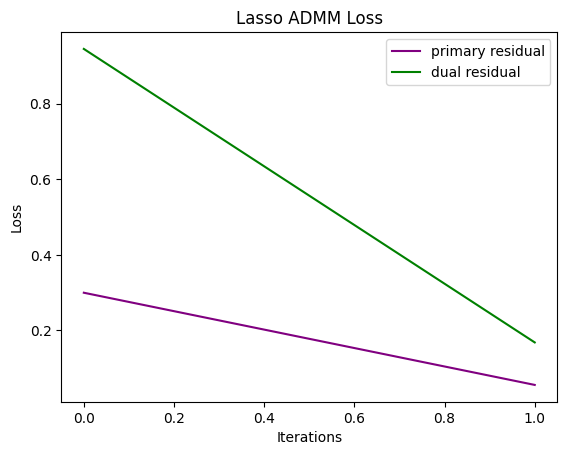

In [21]:
loss_plot_admm(lasso_admm.J, "Lasso ADMM Loss")

Distributed ADMM Lasso

In [22]:
star_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train, y_train, "distributed_admm", agents)
iterations = lasso_distributed_admm.iterations
print("Distributed ADMM iterations:", iterations)
lasso_distributed_admm_predictions = lasso_distributed_admm.predict(X_test)
end_time = time.time()
print("Distributed ADMM time:", end_time - star_time)

Total rows used: 80
Rows per agent: 16
Distributed ADMM iterations: 3
Distributed ADMM time: 0.0029969215393066406


In [23]:
#metrics
distributed_admm_mse = mean_squared_error(y_test, lasso_distributed_admm_predictions)
print("Distributed ADMM MSE:", distributed_admm_mse)

distributed_r2 = r2_score(y_test, lasso_distributed_admm_predictions)
print("Distributed ADMM R2:", distributed_r2)

distributed_mae = mean_absolute_error(y_test, lasso_distributed_admm_predictions)
print("Distributed ADMM MAE:", distributed_mae)

Distributed ADMM MSE: 0.008592150138088164
Distributed ADMM R2: 0.960283450380234
Distributed ADMM MAE: 0.07549204940667446


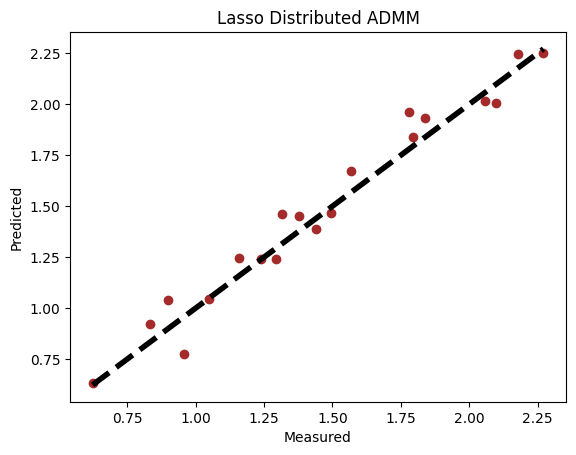

In [24]:
prediction_plot(y_test, lasso_distributed_admm_predictions, "Lasso Distributed ADMM")

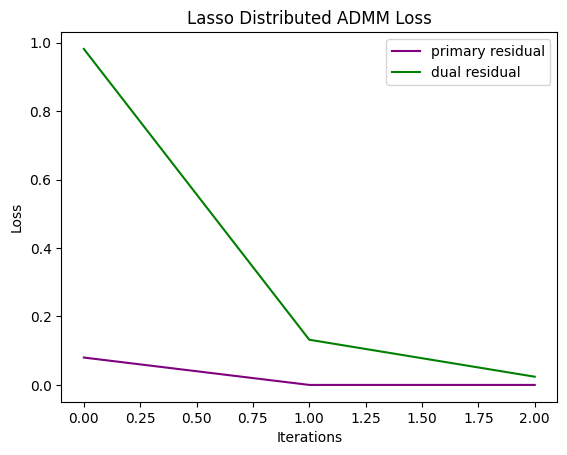

In [25]:
loss_plot_admm(lasso_distributed_admm.J, "Lasso Distributed ADMM Loss")

## Second synthetic Dataset

A more complex dataset is generated to evaluate the performance of the model

# Lasso regression on real dataset

In [26]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,yr_renovated_1930,yr_renovated_1940,yr_renovated_1950,yr_renovated_1960,yr_renovated_1970,yr_renovated_1980,yr_renovated_1990,yr_renovated_2000,yr_renovated_2010
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,5650,False,False,False,False,False,False,False,False,False
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,7639,False,False,False,False,False,False,True,False,False
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,8062,False,False,False,False,False,False,False,False,False
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,5000,False,False,False,False,False,False,False,False,False
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,7503,False,False,False,False,False,False,False,False,False


In [27]:
df.shape

(21613, 26)

In [28]:
X_df = df.drop('price', axis=1)
y_df = df['price']

In [29]:
# Split the data into training and testing sets
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [30]:
# min-max scaling
scaler = MinMaxScaler()
X_df_train = scaler.fit_transform(X_df_train)
X_df_test = scaler.transform(X_df_test)

In [51]:
#lasso parameters
iterations = 500000
step_size = 0.001
l1_penalty = 1
tolerance = 1e-2
agents = 5

Gradient Descent Lasso

In [52]:
star_time = time.time()
lasso_gd = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_gd.fit(X_df_train, y_df_train, "gd")
iterations = lasso_gd.iterations
print("GD iterations:", iterations)
lasso_gd_predictions = lasso_gd.predict(X_df_test)
end_time = time.time()
print("GD time:", end_time - star_time)

GD iterations: 500000
GD time: 1125.6124339103699


In [53]:
#metrics
gd_mse_df = mean_squared_error(y_df_test, lasso_gd_predictions)
print("GD MSE:", gd_mse_df)

r2_df = r2_score(y_df_test, lasso_gd_predictions)
print("GD R2:", r2_df)

mae_df = mean_absolute_error(y_df_test, lasso_gd_predictions)
print("GD MAE:", mae_df)

GD MSE: 50359332707.2182
GD R2: 0.6668843239449787
GD MAE: 135985.34647245257


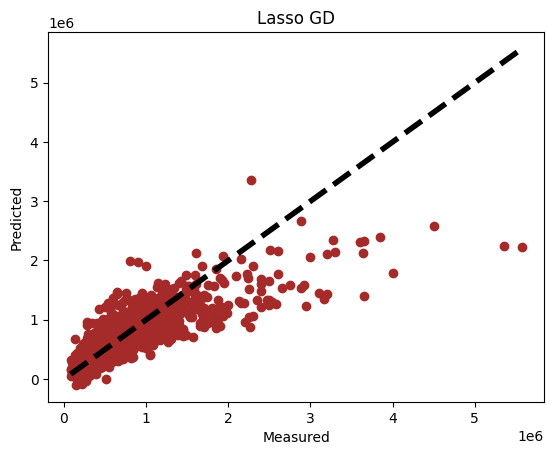

In [54]:
prediction_plot(y_df_test, lasso_gd_predictions, "Lasso GD")

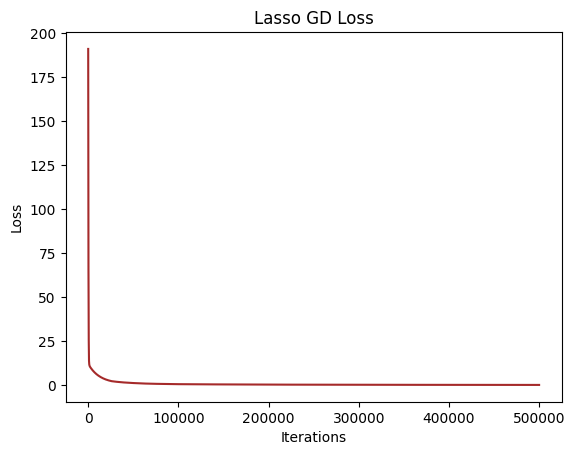

In [55]:
loss_plot(lasso_gd.J, "Lasso GD Loss")

ADMM Lasso regression

In [56]:
star_time = time.time()
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_df_train, y_df_train, "admm")
iterations = lasso_admm.iterations
print("ADMM iterations:", iterations)
lasso_admm_predictions = lasso_admm.predict(X_df_test)
end_time = time.time()
print("ADMM time:", end_time - star_time)

ADMM iterations: 3
ADMM time: 0.00823354721069336


In [57]:
#metrics
admm_mse_df = mean_squared_error(y_df_test, lasso_admm_predictions)
print("ADMM MSE:", admm_mse_df)

admm_r2_df = r2_score(y_df_test, lasso_admm_predictions)
print("ADMM R2:", admm_r2_df)

admm_mae_df = mean_absolute_error(y_df_test, lasso_admm_predictions)
print("ADMM MAE:", admm_mae_df)

ADMM MSE: 49022683571.17906
ADMM R2: 0.6757259577924466
ADMM MAE: 134570.12152796946


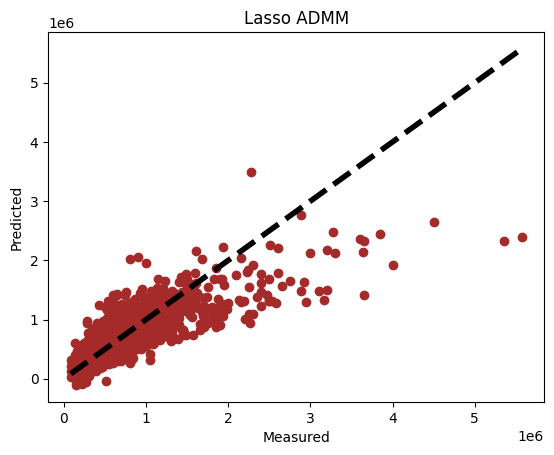

In [58]:
prediction_plot(y_df_test, lasso_admm_predictions, "Lasso ADMM")

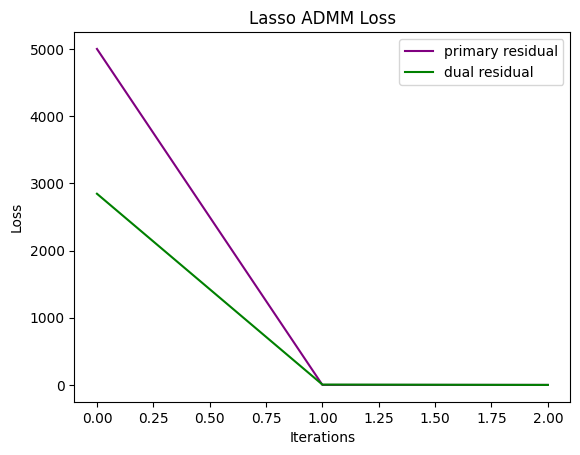

In [59]:
loss_plot_admm(lasso_admm.J, "Lasso ADMM Loss")

Distributed ADMM 

diabetes dataset

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
data_diabete = load_diabetes()
data_diabete.data.shape

(442, 10)

In [ ]:
df_diabete_dataframe = pd.DataFrame(data_diabete.data, columns=data_diabete.feature_names)
df_diabete_dataframe.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [ ]:
X_diabete = df_diabete_dataframe.values
y_diabete = data_diabete.target

In [ ]:
# Split the data into training and testing sets
X_diabete_train, X_diabete_test, y_diabete_train, y_diabete_test = train_test_split(X_diabete, y_diabete, test_size=0.2, random_state=42)

In [ ]:
# min-max scaling
scaler = MinMaxScaler()
X_diabete_train = scaler.fit_transform(X_diabete_train)
X_diabete_test = scaler.transform(X_diabete_test)

In [ ]:
#lasso parameters
iterations = 200000
step_size = 0.1
l1_penalty = 0.1
tolerance = 1e-2
agents = 5

In [ ]:
star_time = time.time()
lasso_gd = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_gd.fit(X_diabete_train, y_diabete_train, "gd")
iterations = lasso_gd.iterations
print("GD iterations:", iterations)
lasso_gd_predictions = lasso_gd.predict(X_diabete_test)
end_time = time.time()
print("GD time:", end_time - star_time)

GD iterations: 962
GD time: 0.0635530948638916


In [ ]:
#metrics
gd_mse_diabete = mean_squared_error(y_diabete_test, lasso_gd_predictions)
print("GD MSE:", gd_mse_diabete)

r2_diabete = r2_score(y_diabete_test, lasso_gd_predictions)
print("GD R2:", r2_diabete)

mae_diabete = mean_absolute_error(y_diabete_test, lasso_gd_predictions)
print("GD MAE:", mae_diabete)

GD MSE: 2892.0490982214806
GD R2: 0.4541400028734155
GD MAE: 43.28064590020791


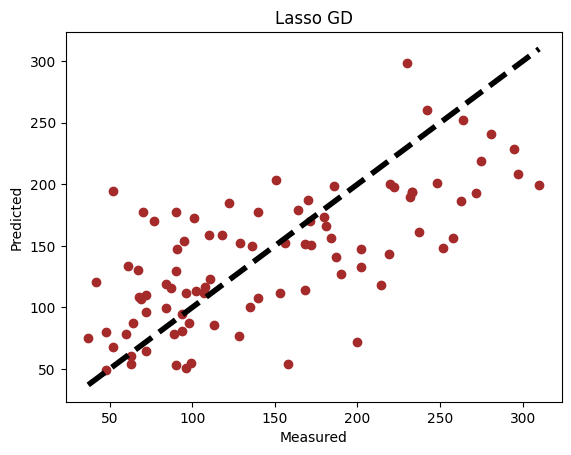

In [ ]:
prediction_plot(y_diabete_test, lasso_gd_predictions, "Lasso GD")

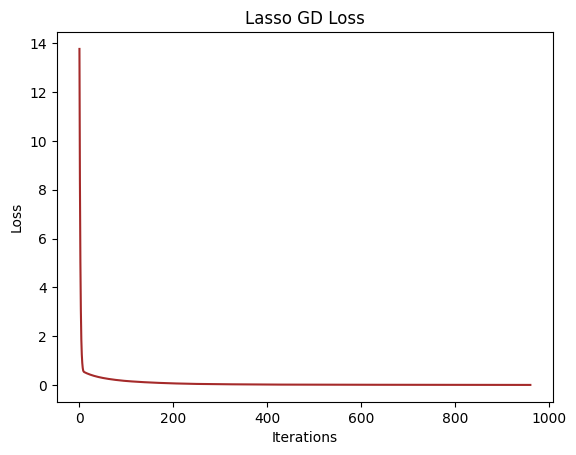

In [ ]:
loss_plot(lasso_gd.J, "Lasso GD Loss")

In [ ]:
star_time = time.time()
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_diabete_train, y_diabete_train, "admm")
iterations = lasso_admm.iterations
print("ADMM iterations:", iterations)
lasso_admm_predictions = lasso_admm.predict(X_diabete_test)
end_time = time.time()
print("ADMM time:", end_time - star_time)

ADMM iterations: 4
ADMM time: 0.0013360977172851562


In [ ]:
#metrics
admm_mse_diabete = mean_squared_error(y_diabete_test, lasso_admm_predictions)
print("ADMM MSE:", admm_mse_diabete)

admm_r2_diabete = r2_score(y_diabete_test, lasso_admm_predictions)
print("ADMM R2:", admm_r2_diabete)

admm_mae_diabete = mean_absolute_error(y_diabete_test, lasso_admm_predictions)
print("ADMM MAE:", admm_mae_diabete)

ADMM MSE: 2891.1957757194173
ADMM R2: 0.45430106328515296
ADMM MAE: 42.78768330047319


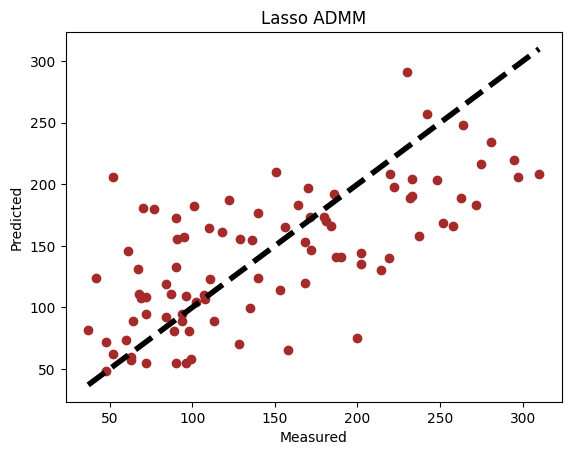

In [ ]:
prediction_plot(y_diabete_test, lasso_admm_predictions, "Lasso ADMM")

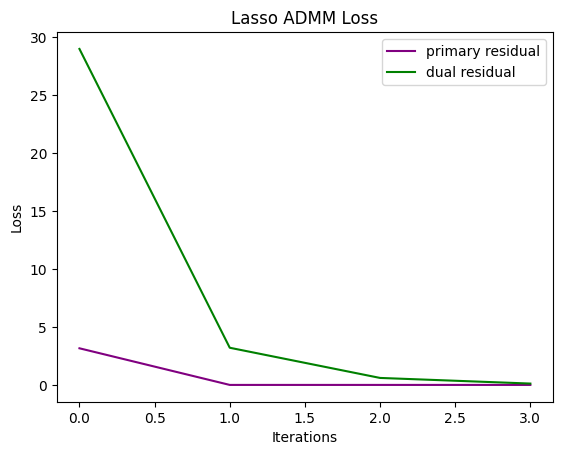

In [ ]:
loss_plot_admm(lasso_admm.J, "Lasso ADMM Loss")

In [ ]:
star_time = time.time()
lasso_distributed_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_diabete_train, y_diabete_train, "distributed_admm", agents)
iterations = lasso_distributed_admm.iterations
print("Distributed ADMM iterations:", iterations)
lasso_distributed_admm_predictions = lasso_distributed_admm.predict(X_diabete_test)
end_time = time.time()  
print("Distributed ADMM time:", end_time - star_time)

Total rows used: 350
Rows per agent: 70
Distributed ADMM iterations: 4
Distributed ADMM time: 0.004082202911376953


In [ ]:
#metrics
distributed_admm_mse_diabete = mean_squared_error(y_diabete_test, lasso_distributed_admm_predictions)
print("Distributed ADMM MSE:", distributed_admm_mse_diabete)

distributed_r2_diabete = r2_score(y_diabete_test, lasso_distributed_admm_predictions)
print("Distributed ADMM R2:", distributed_r2_diabete)

distributed_mae_diabete = mean_absolute_error(y_diabete_test, lasso_distributed_admm_predictions)
print("Distributed ADMM MAE:", distributed_mae_diabete)

Distributed ADMM MSE: 2894.322231434062
Distributed ADMM R2: 0.4537109601958029
Distributed ADMM MAE: 42.63752180888322


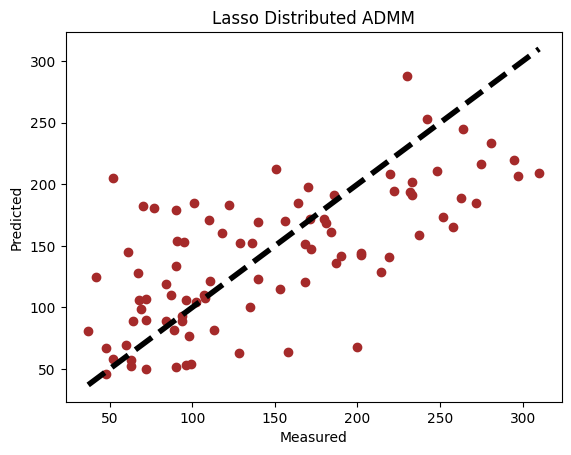

In [ ]:
prediction_plot(y_diabete_test, lasso_distributed_admm_predictions, "Lasso Distributed ADMM")

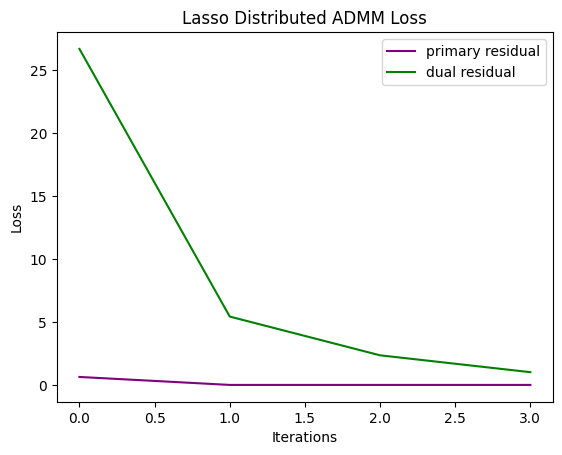

In [ ]:
loss_plot_admm(lasso_distributed_admm.J, "Lasso Distributed ADMM Loss")

New dataset

In [ ]:
data = pd.read_csv('California_cleaned.csv')

In [ ]:
# Split the data into training and testing sets
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# min-max scaling
scaler = MinMaxScaler()
X_train_cal = scaler.fit_transform(X_train_cal)
X_test_cal = scaler.transform(X_test_cal)


In [ ]:
#lasso parameters
iterations = 200000
step_size = 0.1
l1_penalty = 1
tolerance = 1e-3
agents = 5

In [ ]:
star_time = time.time()
lasso_gd = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_cal, y_train_cal, "gd")
iterations = lasso_gd.iterations
print("GD iterations:", iterations)
lasso_gd_predictions = lasso_gd.predict(X_test_cal)
end_time = time.time()
print("GD time:", end_time - star_time)

GD iterations: 161533
GD time: 225.8875675201416


In [ ]:
#metrics
gd_mse_cal = mean_squared_error(y_test_cal, lasso_gd_predictions)
print("GD MSE:", gd_mse_cal)

r2_cal = r2_score(y_test_cal, lasso_gd_predictions)
print("GD R2:", r2_cal)

mae_cal = mean_absolute_error(y_test_cal, lasso_gd_predictions)
print("GD MAE:", mae_cal)

GD MSE: 3837523804.377668
GD R2: 0.5850852116310485
GD MAE: 46084.13329272785


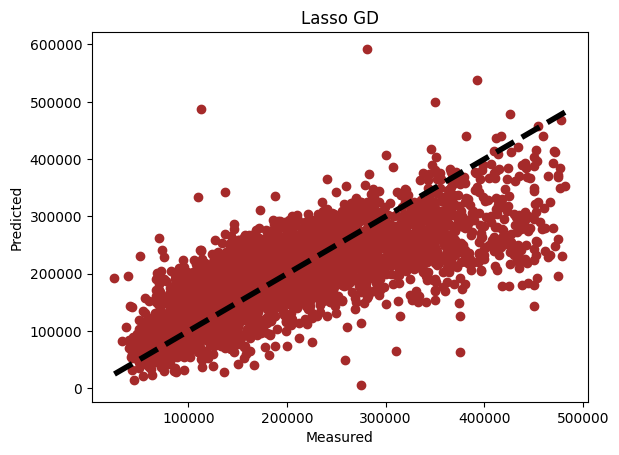

In [ ]:
prediction_plot(y_test_cal, lasso_gd_predictions, "Lasso GD")

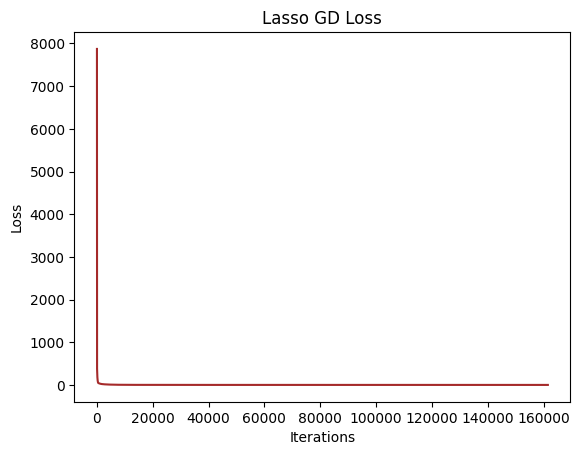

In [ ]:
loss_plot(lasso_gd.J, "Lasso GD Loss")

In [ ]:
star_time = time.time()
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_cal, y_train_cal, "admm")
iterations = lasso_admm.iterations
print("ADMM iterations:", iterations)
lasso_admm_predictions = lasso_admm.predict(X_test_cal)
end_time = time.time()
print("ADMM time:", end_time - star_time)

ADMM iterations: 5
ADMM time: 0.0064258575439453125


In [ ]:
#metrics
admm_mse_cal = mean_squared_error(y_test_cal, lasso_admm_predictions)
print("ADMM MSE:", admm_mse_cal)

admm_r2_cal = r2_score(y_test_cal, lasso_admm_predictions)
print("ADMM R2:", admm_r2_cal)

admm_mae_cal = mean_absolute_error(y_test_cal, lasso_admm_predictions)
print("ADMM MAE:", admm_mae_cal)


ADMM MSE: 3835652185.223852
ADMM R2: 0.5852875719302151
ADMM MAE: 46051.975117885675


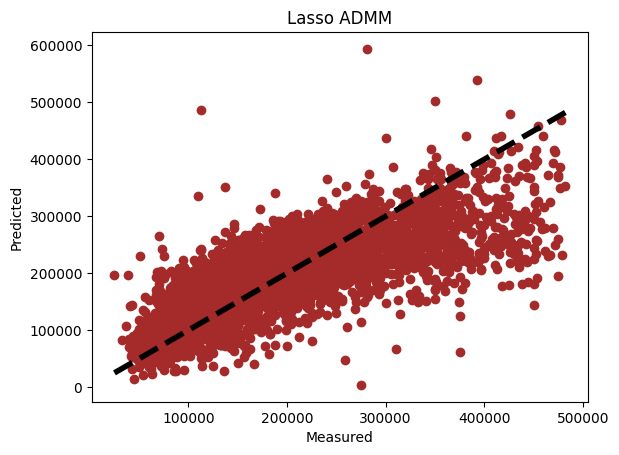

In [ ]:
prediction_plot(y_test_cal, lasso_admm_predictions, "Lasso ADMM")

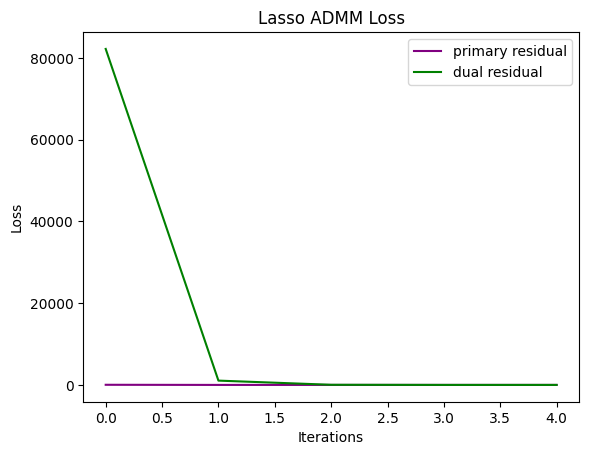

In [ ]:
loss_plot_admm(lasso_admm.J, "Lasso ADMM Loss")

Medical

In [ ]:
med_data = pd.read_csv('Medicalpremium.csv')

In [ ]:
med_data.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [ ]:
med_data.shape

(986, 11)

In [ ]:
med_data.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

In [ ]:
#check for duplicates
med_data.duplicated().sum()

0

In [ ]:
# split the data into training and testing sets
X = med_data.drop('PremiumPrice', axis=1)
Y = med_data['PremiumPrice']

In [ ]:
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# min-max scaling
scaler = MinMaxScaler()
X_train_med = scaler.fit_transform(X_train_med)
X_test_med = scaler.transform(X_test_med)


In [ ]:
#lasso parameters
iterations = 200000
step_size = 0.1
l1_penalty = 1
tolerance = 1e-3
agents = 5

In [ ]:
# gd
star_time = time.time()
lasso_gd = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_med, y_train_med, "gd")
iterations = lasso_gd.iterations
print("GD iterations:", iterations)
lasso_gd_predictions = lasso_gd.predict(X_test_med)
end_time = time.time()
print("GD time:", end_time - star_time)

GD iterations: 1338
GD time: 0.417513370513916


In [ ]:
#metrics
gd_mse_med = mean_squared_error(y_test_med, lasso_gd_predictions)
print("GD MSE:", gd_mse_med)

r2_med = r2_score(y_test_med, lasso_gd_predictions)
print("GD R2:", r2_med)

mae_med = mean_absolute_error(y_test_med, lasso_gd_predictions)
print("MAE:", mae_med)

GD MSE: 27860729.898121495
GD R2: 0.3466485451773481
MAE: 4210.1588804536295


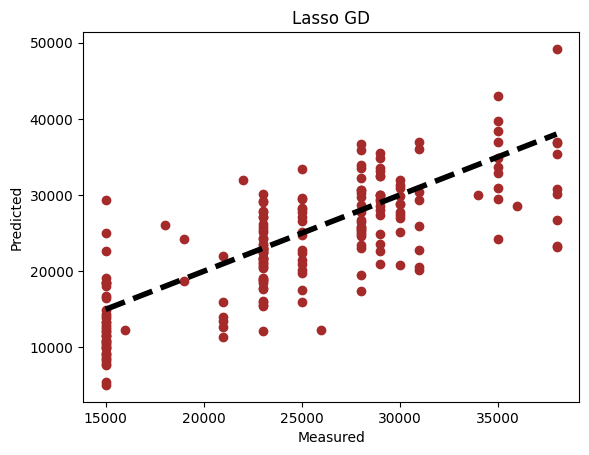

In [ ]:
prediction_plot(y_test_med, lasso_gd_predictions, "Lasso GD")

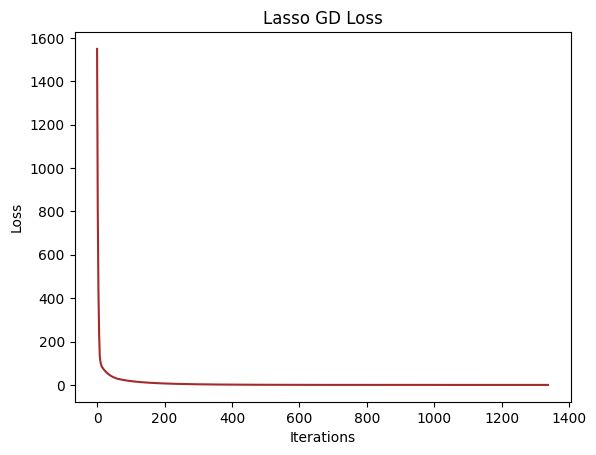

In [ ]:
loss_plot(lasso_gd.J, "Lasso GD Loss")

In [ ]:
start_time = time.time()
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_med, y_train_med, "admm")
iterations = lasso_admm.iterations
print("ADMM iterations:", iterations)


In [ ]:
np.random.seed(42)

n_samples, n_features = 1000, 10

In [ ]:
#weight vector with some zeros
true_weights = np.zeros(n_features)
true_weights[2] = 3.0
true_weights[5] = -2.0

In [ ]:
#Noise
X_synthetic = np.random.randn(n_samples, n_features)
Y_synthetic = X_synthetic.dot(true_weights) + 0.5 * np.random.randn(n_samples)

In [ ]:
X_synthetic = np.column_stack((X_synthetic, np.ones(n_samples)))

In [ ]:
columns = [f'Feature_{i}' for i in range(n_features)] + ['Bias', 'Target']
synthetic_data = pd.DataFrame(data=np.column_stack((X_synthetic, Y_synthetic)), columns=columns)

In [ ]:
synthetic_data.head()

In [ ]:
X_train_synthetic, X_test_synthetic, Y_train_synthetic, Y_test_synthetic = train_test_split(synthetic_data.drop(columns=['Target']), synthetic_data['Target'], test_size=0.2, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train_synthetic_normalized = scaler.fit_transform(X_train_synthetic)
X_test_synthetic_normalized = scaler.transform(X_test_synthetic)

## Lasso on sythtetic data

In [ ]:
# parameters
iterations = 10000
step_size = 0.01
l1_penalty = 1
tolerance = 1e-4
agents = 5

In [ ]:
start_time = time.time()
lasso = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso.fit(X_train_synthetic_normalized, Y_train_synthetic, "gd")
numer_iterations = lasso.iterations
print("GD time:", time.time() - start_time)
print("GD iterations:", numer_iterations)

In [ ]:
plot_convergence(lasso, "GD")

In [ ]:
# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_synthetic_normalized, Y_train_synthetic, "admm")
numer_iterations = lasso.iterations
print("ADMM time:", time.time() - start_time)
print("ADMM iterations:", numer_iterations)

In [ ]:
plot_convergence(lasso_admm, "ADMM")